In [2]:
#-*-coding:utf-8-*-
from GameEnv import Game2048
from DQN import DQN
import random
import copy

def check_one_game(gameEnv,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()

        action = random.choice(["a","w","d","s"])
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score

gameEnv = Game2048()
gameEnv.grid_n = 2

In [3]:
import numpy as np
scores = []
n = 1000
for i in range(n):
    scores.append(check_one_game(gameEnv,False))
print np.average(scores)
print np.max(scores)
print np.min(scores)
# print np.sort(scores)

25.192
120
0


In [4]:
check_one_game(gameEnv,True)

2	 -	 

-	 2	 

_________________________________________
2	 2	 

2	 -	 

_________________________________________
2	 4	 

-	 2	 

_________________________________________
2	 4	 

-	 2	 

_________________________________________
2	 4	 

-	 2	 

_________________________________________
2	 4	 

-	 2	 

_________________________________________
2	 4	 

-	 2	 

_________________________________________
2	 4	 

2	 4	 

_________________________________________
2	 4	 

2	 4	 

_________________________________________
2	 -	 

4	 8	 

_________________________________________
2	 8	 

4	 2	 

_________________________________________
2	 8	 

4	 2	 

('this_score_____________________:', 16)


16

In [5]:
# 策略评估
import itertools
import numpy as np
def move(mtr, dirct):
    grid_n = 2
    score = 0
    visit = []
    if dirct == 0:  # left
        for i in range(grid_n):
            for j in range(1, grid_n):
                for k in range(j, 0, -1):
                    if mtr[i][k - 1] == 0:
                        mtr[i][k - 1] = mtr[i][k]
                        mtr[i][k] = 0
                    elif mtr[i][k - 1] == mtr[i][k] and grid_n * i + k - 1 not in visit and grid_n * i + k not in visit:
                        mtr[i][k - 1] *= 2
                        mtr[i][k] = 0
                        score += mtr[i][k - 1]
                        visit.append(grid_n * i + k)
                        visit.append(grid_n * i + k - 1)
                        # for i in range(4):
                        #    for j in range(3):

    elif dirct == 1:  # down
        for j in range(grid_n):
            for i in range(grid_n-1, 0, -1):
                for k in range(0, i):
                    if mtr[k + 1][j] == 0:
                        mtr[k + 1][j] = mtr[k][j]
                        mtr[k][j] = 0
                    elif mtr[k + 1][j] == mtr[k][j] and (grid_n * (k + 1) + j) not in visit and (grid_n * k + j) not in visit:
                        mtr[k + 1][j] *= 2
                        mtr[k][j] = 0
                        score += mtr[k + 1][j]
                        visit.append(grid_n * (k) + j)
                        visit.append(grid_n * (k + 1) + j)


    elif dirct == 2:  # up
        for j in range(grid_n):
            for i in range(1, grid_n):
                for k in range(i, 0, -1):
                    if mtr[k - 1][j] == 0:
                        mtr[k - 1][j] = mtr[k][j]
                        mtr[k][j] = 0
                    elif mtr[k - 1][j] == mtr[k][j] and (grid_n * (k - 1) + j) not in visit and (grid_n * k + j) not in visit:
                        mtr[k - 1][j] *= 2
                        mtr[k][j] = 0
                        score += mtr[k - 1][j]
                        visit.append(grid_n * (k) + j)
                        visit.append(grid_n * (k - 1) + j)

    elif dirct == 3:  # right
        for i in range(grid_n):
            for j in range(grid_n-1, 0, -1):
                for k in range(j):
                    if mtr[i][k + 1] == 0:
                        mtr[i][k + 1] = mtr[i][k]
                        mtr[i][k] = 0
                    elif mtr[i][k] == mtr[i][k + 1] and grid_n * i + k + 1 not in visit and grid_n * i + k not in visit:
                        mtr[i][k + 1] *= 2
                        mtr[i][k] = 0
                        score += mtr[i][k + 1]
                        visit.append(grid_n * i + k + 1)
                        visit.append(grid_n * i + k)

    return score

def test_step(matrix,action):
    if action == "a":
            dirct = 0
    elif action == "s":
        dirct = 1
    elif action == "w":
        dirct = 2
    elif action == "d":
        dirct = 3
            
    tmp = copy.deepcopy(matrix)
    score = move(matrix,dirct)
    res_list = []
    if tmp == matrix:
        return [tmp],0
    for i in range(2):
        for j in range(2):
            if matrix[i][j] == 0:
                copy_matrix_2 = copy.deepcopy(matrix)
                copy_matrix_4 = copy.deepcopy(matrix)
                copy_matrix_2[i][j] = 2
                copy_matrix_4[i][j] = 4
                res_list.append(copy_matrix_2)
                res_list.append(copy_matrix_4)
    return res_list,score
        

def policy_evaluate(hold=0.001,value_dict=None,policy = ["a","s","w","d"],debug=False):
    if value_dict is None:
        # 初始化所有状态，包含了部分不存在的状态
        v_dict = {}
        for s in list(itertools.permutations([0,0,0,2,2,2,4,4,4,8,8,8,16,16,16,32],4)):
            v_dict[str(s)] = 0
    else:
        print "use old"
        v_dict = value_dict
    s_list = v_dict.keys()
    
    # 循环，没有模拟随机产出这个步骤
    while True:
        delta = 0
        for s in s_list:
            v = v_dict[s]      # v ← V（s）
            vs = 0
            action_list = ["a","s","w","d"] if policy == ["a","s","w","d"] else policy[s]
            for action in action_list:                
                gameEnv.matrix = np.array(eval(s)).reshape(2,2).tolist()
                observation_next_list, reward = test_step(gameEnv.matrix,action)
                for i in range(len(observation_next_list)):
                    if str(tuple(np.array(observation_next_list[i]).reshape(-1))) not in v_dict:
                        continue
                    vs += (1.0 / len(action_list)) * (1.0 / len(observation_next_list)) * (reward + v_dict[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])              
                    # V(s) ← Σa π（a|s） Σp(s'|s,a)[r + γV（s'）]  

            v_dict[s] = vs
            delta = max(delta,abs(v - vs)) # Δ ← max(Δ，|v - V（s）|)
        if debug:print delta,v_dict[str((2,2,0,0))]
        if delta < hold:
            break
    return v_dict

# 策略评估

In [18]:
res = policy_evaluate(hold=0.1,value_dict=None,policy=['a','s','w','d'],debug=True)

32.625 3.3416917589
15.661026001 6.74232229707
9.23770427704 9.61023932449
7.40366089344 12.1103345182
5.34032875299 14.353583936
3.89149193838 16.3468085088
2.79816939309 18.0728924383
1.94477942958 19.5290755138
1.67190419402 20.7316217534
1.43237644258 21.7089537923
1.20383337423 22.4940873107
0.997406268603 23.1195203821
0.823514488781 23.6145910874
0.67279447953 24.004506956
0.544798630178 24.3102997516
0.437820433342 24.5492064515
0.349542532322 24.7351954128
0.277453704988 24.8794998634
0.219098552115 24.9911013174
0.172213502679 25.077145669
0.134789553693 25.1432924138
0.10512471816 25.1940039481
0.0817376335681 25.232783407


In [19]:
res

{'(8, 8, 2, 16)': 36.76925476048409,
 '(0, 8, 2, 0)': 15.577888233594189,
 '(16, 8, 8, 16)': 0.0,
 '(2, 16, 0, 4)': 6.658817823450903,
 '(4, 16, 8, 2)': 0.0,
 '(32, 4, 4, 2)': 0.0,
 '(16, 8, 8, 32)': 0.0,
 '(8, 8, 2, 4)': 22.65863751217393,
 '(0, 2, 16, 0)': 10.689565756707335,
 '(32, 4, 2, 8)': 0.0,
 '(2, 2, 2, 16)': 13.730835262283714,
 '(16, 32, 0, 16)': 0.0,
 '(0, 8, 32, 4)': 8.49974288418889,
 '(0, 8, 16, 32)': 0.0,
 '(8, 0, 16, 2)': 4.284825229914623,
 '(8, 4, 0, 32)': 8.49974288418889,
 '(2, 32, 4, 8)': 0.0,
 '(32, 4, 0, 0)': 9.021106187212926,
 '(0, 4, 4, 0)': 21.81887660307754,
 '(32, 16, 16, 0)': 0.0,
 '(2, 0, 16, 8)': 4.285349450563636,
 '(32, 8, 4, 16)': 0.0,
 '(2, 8, 2, 2)': 19.56710634577701,
 '(16, 16, 2, 32)': 0.0,
 '(2, 16, 16, 2)': 0.0,
 '(32, 4, 8, 16)': 0.0,
 '(0, 16, 4, 4)': 11.380642840825564,
 '(2, 8, 4, 4)': 21.2320400204261,
 '(8, 8, 0, 4)': 17.53093345261943,
 '(2, 16, 0, 32)': 1.9999791979789734,
 '(0, 32, 4, 2)': 9.23348148423247,
 '(16, 2, 8, 2)': 17.144829

In [20]:
status = str((2,2,2,0))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i])

2	 2	 

2	 -	 

a 21.879034243398266
s 21.87941171555171
w 21.880148117144834
d 21.87767909317921


In [21]:
status = str((4,4,0,2))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i]),statis_dict[i]

4	 4	 

-	 2	 

a 15.584259507333176 [19.68351489297108, 10.25841538751843, 17.185074380565204, 15.210033368277994]
s 9.130934508687155 [0.0, 18.26186901737431]
w 18.761480136020637 [18.761480136020637]
d 15.582859228754556 [19.680885977641942, 10.25920625560979, 17.183839491405955, 15.207505190360536]


# 策略迭代

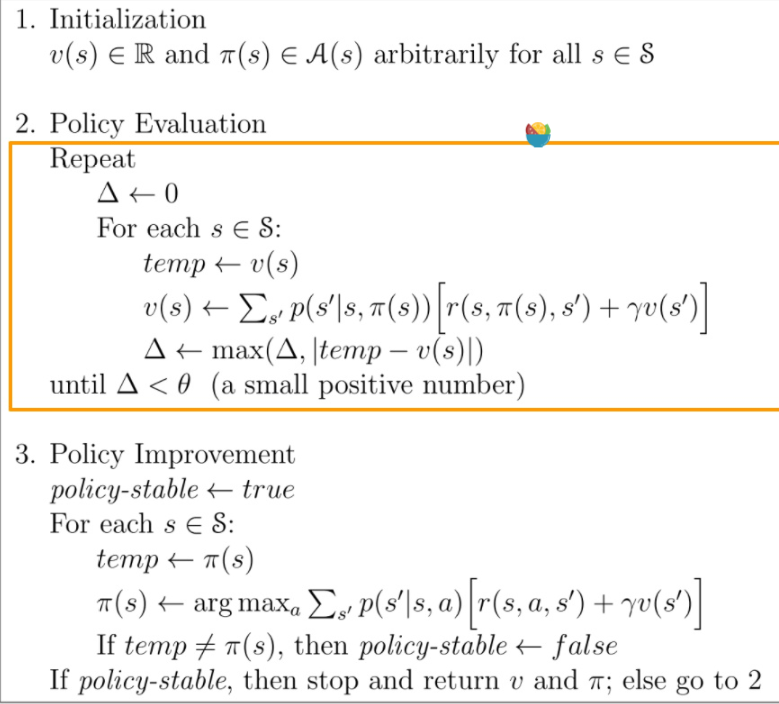

In [23]:
def optimize():
    # 策略评估
    res = policy_evaluate(0.0001)
    policy_before = {}
    while True:
        # 策略迭代
        policy = {}
        for s in res:
            max_score = -1
            max_action = ["a"]
            for action in ["a","s","w","d"]:                
                observation_next_list, reward = test_step(np.array(eval(s)).reshape(2,2).tolist(),action)
                statis_dict = {}
                for i in range(len(observation_next_list)):
                    if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in res:
                        if action in statis_dict:
                            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                        else:
                            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
                for i in statis_dict:
                    if len(statis_dict[i]) > 1:
                        if np.average(statis_dict[i]) > max_score:
                            max_score = np.average(statis_dict[i])
                            max_action = [i]
                policy[s] = max_action
        # 策略评估
        res = policy_evaluate(0.0001,res,policy)
        
        # 策略不变时退出
        if policy == policy_before:
            break
        
        policy_before = copy.deepcopy(policy)
    return policy,res

In [51]:
policy,res = optimize()

use old
use old
use old


In [24]:
policy

{'(8, 8, 2, 16)': ['d'],
 '(0, 8, 2, 0)': ['a'],
 '(2, 16, 0, 4)': ['s'],
 '(32, 4, 4, 2)': ['a'],
 '(0, 2, 16, 0)': ['a'],
 '(2, 2, 2, 16)': ['s'],
 '(8, 8, 8, 16)': ['s'],
 '(0, 32, 8, 8)': ['a'],
 '(8, 4, 0, 32)': ['a'],
 '(8, 8, 2, 0)': ['a'],
 '(0, 4, 4, 0)': ['a'],
 '(2, 4, 2, 8)': ['w'],
 '(16, 2, 16, 4)': ['s'],
 '(2, 2, 0, 0)': ['s'],
 '(32, 8, 4, 16)': ['a'],
 '(2, 8, 2, 2)': ['w'],
 '(16, 16, 2, 32)': ['a'],
 '(8, 32, 0, 2)': ['a'],
 '(32, 4, 8, 16)': ['a'],
 '(0, 16, 4, 4)': ['a'],
 '(2, 8, 4, 4)': ['d'],
 '(8, 8, 0, 4)': ['a'],
 '(8, 8, 2, 4)': ['d'],
 '(2, 0, 4, 4)': ['a'],
 '(8, 32, 2, 8)': ['a'],
 '(0, 16, 32, 8)': ['a'],
 '(2, 2, 0, 8)': ['a'],
 '(16, 32, 0, 2)': ['a'],
 '(32, 2, 2, 16)': ['a'],
 '(4, 4, 8, 16)': ['a'],
 '(2, 8, 0, 2)': ['a'],
 '(2, 16, 16, 16)': ['s'],
 '(4, 0, 2, 2)': ['a'],
 '(2, 32, 8, 4)': ['a'],
 '(8, 32, 16, 0)': ['s'],
 '(0, 0, 32, 16)': ['w'],
 '(0, 8, 8, 16)': ['a'],
 '(8, 0, 4, 0)': ['d'],
 '(16, 32, 4, 8)': ['a'],
 '(0, 4, 32, 0)': ['a'],
 

In [60]:
# 策略迭代测试
def check_one_game_with_policy(gameEnv,policy,debug):
    gameEnv.reset()
    flag = False
    observation = copy.deepcopy(gameEnv.matrix)
    while True:
        if debug:gameEnv.display()

        action = policy[str(tuple(np.array(observation).reshape(-1).tolist()))][0]
        if debug:print "choose:",action
        observation_, reward, done = gameEnv.step(action)
        flag = True if observation_ == observation else False
        observation = copy.deepcopy(observation_)
        if debug:print("_________________________________________")
        if done:
            if debug:gameEnv.display()
            if debug:print("this_score_____________________:",gameEnv.score)
            break
    return gameEnv.score
def evaluate(gameEnv,policy):
    scores = []
    n = 10000
    for i in range(n):
        scores.append(check_one_game_with_policy(gameEnv,policy,False))
    print "avg:%d max:%d min:%d "%(np.average(scores),np.max(scores), np.min(scores))
    
evaluate(gameEnv,policy)

avg:59 max:172 min:12 


# 值迭代

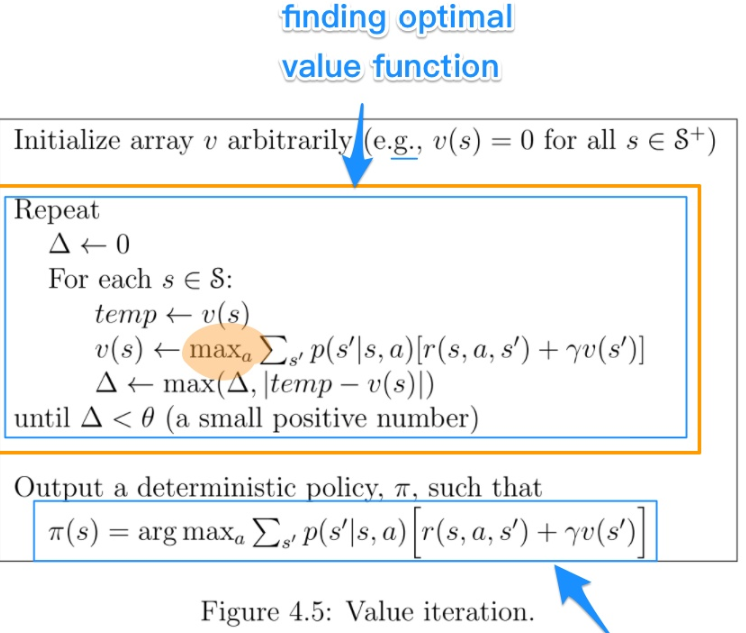

In [27]:
def value_iteration():
    hold = 0.000001
    # 初始化所有状态，包含了部分不存在的状态
    v_dict = {}
    for s in list(itertools.permutations([0,0,0,2,2,2,4,4,4,8,8,8,16,16,16,32],4)):
        v_dict[str(s)] = 0
    s_list = v_dict.keys()
    
    while True:
        delta = 0
        for s in s_list:
            temp = v_dict[s]
            # find max_a v
            max_score = 0
            max_action = ["a"]
            for action in ["a","s","w","d"]:                
                observation_next_list, reward = test_step(np.array(eval(s)).reshape(2,2).tolist(),action)
                statis_dict = {}
                for i in range(len(observation_next_list)):
                    if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in v_dict:
                        if action in statis_dict:
                            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                        else:
                            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
                for i in statis_dict:
                    if len(statis_dict[i]) > 1:
                        if np.average(statis_dict[i]) > max_score:
                            max_score = np.average(statis_dict[i])
                            max_action = [i]
            vs = max_score
            v_dict[s] = vs
            delta = max(delta,abs(temp - vs))
        if delta < hold:
            break
    return v_dict

def get_policy(res):
     # 策略迭代
    policy = {}
    for s in res:
        max_score = -2
        max_action = ["a"]
        for action in ["a","s","w","d"]:                
            observation_next_list, reward = test_step(np.array(eval(s)).reshape(2,2).tolist(),action)
            statis_dict = {}
            for i in range(len(observation_next_list)):
                if str(tuple(np.array(observation_next_list[i]).reshape(-1))) in res:
                    if action in statis_dict:
                        statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
                    else:
                        statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
            for i in statis_dict:
                if len(statis_dict[i]) > 1:
                    if np.average(statis_dict[i]) > max_score:
                        max_score = np.average(statis_dict[i])
                        max_action = [i]
            policy[s] = max_action
    return policy

In [28]:
res = value_iteration()

In [29]:
policy = get_policy(res)

In [32]:
status = str((2,2,2,0))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i]),statis_dict[i]
print policy[status]

2	 2	 

2	 -	 

a 51.556081771850586 [55.54377746582031, 47.53007507324219, 55.46715545654297, 47.683319091796875]
s 51.556081771850586 [55.54377746582031, 47.53007507324219, 55.46715545654297, 47.683319091796875]
w 51.556081771850586 [55.54377746582031, 47.53007507324219, 55.46715545654297, 47.683319091796875]
d 51.556081771850586 [55.54377746582031, 47.53007507324219, 55.46715545654297, 47.683319091796875]
['a']


In [39]:
status = str((2,2,0,0))
gameEnv.display(np.array(eval(status)).reshape(2,2).tolist())
for action in ["a","s","w","d"]:                
    gameEnv.matrix = np.array(eval(status)).reshape(2,2).tolist()
    observation_next_list, reward = test_step(gameEnv.matrix,action)
    statis_dict = {}
    for i in range(len(observation_next_list)):
        if action in statis_dict:
            statis_dict[action].append(res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))])
        else:
            statis_dict[action] = [res[str(tuple(np.array(observation_next_list[i]).reshape(-1)))]]
    for i in statis_dict:
        print i,np.average(statis_dict[i]),statis_dict[i]
print policy[status]

2	 2	 

-	 -	 

a 55.01161861419678 [54.556081771850586, 55.46715545654297, 54.556081771850586, 55.46715545654297, 54.556081771850586, 55.46715545654297]
s 55.01161861419678 [54.556081771850586, 55.46715545654297, 54.556081771850586, 55.46715545654297]
w 59.01161861419678 [59.01161861419678]
d 55.01161861419678 [54.556081771850586, 55.46715545654297, 54.556081771850586, 55.46715545654297, 54.556081771850586, 55.46715545654297]
['a']


In [53]:
evaluate(gameEnv,policy)

avg:59 max:168 min:12 


In [63]:
print policy[str((0,4,2,8))]

['w']


In [59]:
for i in range(10000):
    if check_one_game_with_policy(gameEnv,policy,True) == 168:
        break

-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_____________________________

choose: w
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 56)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 4	 

32	 -	 

choose: a
_________________________________________
8	 -	 

32	 2	 

choose: w
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 128)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_______________________________________

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
-	 2	 

32	 4	 

choose: a
_________________________________________
2	 4	 

32	 4	 

choose: s
_________________________________________
2	 4	 

32	 8	 

choose: a
_________________________________________
2	 4	 

32	 8	 

('this_score_____________________:', 120)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
______________________________________

2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	 4	 

choose: s
_________________________________________
2	 4	 

4	 8	 

choose: a
_________________________________________
2	 4	 

4	 8	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)


4	 -	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
-	 2	 

16	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
__________________________________

_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 2	 

32	 2	 

choose: s
_________________________________________
8	 4	 

32	 4	 

choose: w
_____________________________________

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	

2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
__________________________

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 4	 

8	 8	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
-	 4	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

('this_score_____________________:', 112)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
________________________________

('this_score_____________________:', 56)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 2	 

choose: w
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

32	 8	 

choose: a
_________________________________________
2	 4	 

32	 8	 

choose: a
_________________________________________
2	 4	 

32	 8	 

('this_score_____________________:', 112)
2	 2	 



4	 2	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

2	 32	 

choose: w
_________________________________________
4	 4	 

4	 32	 

choose: s
_________________________________________
4	 4	 

8	 32	 

choose: a
_________________________________________
8	 2	 

8	 32	 

choose: s
_________________


8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

2	 16	 

choose: w
_________________________________________
4	 4	 

2	 16	 

choose: d
_________________________________________
2	 8	 

2	 16	 

choose: s
_________________________________________
4	 8	 

4	 16	 

choose: w
_________________________________________
8	 8	 

2	 16	 

choose: d
_________________________________________
2	 16	 

2	 16	 

choose: s
_________________________________________
4	 -	 

4	 32	 

choose: s
_________________________________________
-	 2	 

8	 32	 

choose: a
_________________________________________
2	 4	 

8	 32	 

choose: a
_________________________________________
2	 4	 

8	 32	 

('this_score_____________________:', 124)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
____________________________

4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 -	 

choose: s
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 124)
2	 -	 

-	 2	 

choose: a
_______________________

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_____________________________________

8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 -	 

32	 2	 

choose: w
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 116)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 4	 

choose: w
______________________

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 4	 

16	 16	 

choose: a
_________________________________________
8	 -	 

32	 4	 

choose: w
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 112)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
________________________________

8	 2	 

choose: s
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
____________________________________

2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_____________________________


choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

2	 16	 

choose: w
_________________________________________
4	 4	 

2	 16	 

choose: d
_________________________________________
4	 8	 

2	 16	 

choose: a
_________________________________________
4	 8	 

2	 16	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	

2	 -	 

16	 4	 

choose: d
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
-	 2	 

-	 2	 

choose: a
_____________________________________

4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 2	 

choose: a
_________________________________________
16	 4	 

8	 2	 

('this_score_____________________:', 56)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

2	 16	 

choose: w
_________________________________________
4	 4	 

2	 16	 

choose: d
___________________________

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2

-	 4	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 4	 

8	 8	 

choose: a
_________________________________________
16	 4	 

16	 2	 

choose: w
_________________________________________
32	 4	 

4	 2	 

choose: a
_________________________________________
32	 4	 

4	 2	 

('this_score_____________________:', 108)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
________________________

_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16

2	 4	 

4	 -	 

choose: s
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

2	 32	 

choose: w
_________________________________________
4	 4	 

2	 32	 

choose: d
_________________________________________
2	 8	 

2	 32	 

choose: s
____________

_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 124)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 12)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 


choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 44)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
___________________________________

2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 60)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 16)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
________________________________________


2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: s
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 16)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
____________________________________

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_____________________________________

-	 4	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 2	 

choose: a
_________________________________________
16	 4	 

8	 2	 

('this_score_____________________:', 52)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_____________________________

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 2	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 2	 

32	 2	 

choose: s
_________________________________________
8	 4	 

32	 4	 

choose: w
_________________________________________
8	 8	 

32	 4	 

choose: a
_________________________________________
16	 4	 

32	 4	 

choose: s
_________________________________________
16	 4	 

32	 8	 

choose: a
_________________________________________
16	 4	 

32	 8	 

('this_score_____________________:', 156)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
___________________________________


2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 36)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 4	 


2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

2	 32	 

choose: w
_________________________________________
4	 4	 

4	 32	 

choose: s
_________________________________________
4	 4	 

8	 32	 

choose: a
_________________________________________
8	 4	 

8	 32	 

choose: s
_________________________________________
4	 4	 

16	 32	 

choose: a
_________________________________________
8	 4	 

16	 32	 

choose: a
_________________________________________
8	 4	 

16	 32	 

('this_score_____________________:', 156)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________

4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 56)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
____________________________


('this_score_____________________:', 16)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

2	 32	 

choose: w
_________________________________________
4	 4	 

2	 32	 

choose: d
_________________________________________
4	 8	 

2	 32	 

choose: a
_________________________________________
4	 8	 

2	 32	 

('this_score_____________________:', 112)
-	 2	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 108)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
________________________________________

_________________________________________
4	 4	 

16	 16	 

choose: a
_________________________________________
8	 -	 

32	 4	 

choose: w
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 120)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose

8	 8	 

choose: a
_________________________________________
2	 4	 

16	 -	 

choose: s
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 4	 

16	 16	 

choose: a
_________________________________________
8	 -	 

32	 2	 

choose: w
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 120)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
______________________________

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 44)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 2	 


choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________

-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

2	 32	 

choose: w
_________________________________________
4	 4	 

4	 32	 

choose: s
_________________________________________
2	 4	 

8	 32	 

choose: a
_________________________________________
2	 4	 

8	 32	 

('this_score_____________________:', 124)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
______________________

4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 44)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
____________________________

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 44)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 4	 

4	 2	 

choose: a
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	


('this_score_____________________:', 120)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

2	 4	 

choose: w
_________________________________________
16	 8	 

2	 2	 

choose: a
_________________________________________
16	 8	 

4	 4	 

choose: d
_________________________________________
16	 8	 

2	 8	 

choose: w
_________________________________________
16	 16	 

2	 4	 

choose: d
________________________________________

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 4	 

choose: a
_________________________________________
4	 8	 

2	 4	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

4	 16	 

choose: a
_________________________________________
2	 4	 

4	 16	 

('this_score_____________________:', 40)
-	 2	 



4	 2	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
2	 -	 

32	 4	 

choose: d
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 116)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_______________________________

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	 4	 

choose: s
_________________________________________
2	 4	 

4	 8	 

choose: a
_________________________________________
2	 4	 

4	 8	 

('this_score_____________________:', 12)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

4	 16	 

choose: a
_________________________________________
2	 4	 

4	 16	 

('this_score_____________________:', 40)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	


choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 16)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 


-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_____________________________

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

16	 2	 

choose: a
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 56)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 

('this_score_____________________:', 56)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 



choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 4	 

choose: w
_________________________________________
8	 8	 

4	 4	 

choose: a
_________________________________________
16


choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
________________________________________

4	 -	 

4	 2	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
______________________________

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 2	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 -	 

choose: s
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 16)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 4	 

4	 2	 

choose: a
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	


choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
-	 2	 

32	 4	 

choose: a
_________________________________________
2	 4	 

32	 4	 

choose: s
_________________________________________
2	 4	 

32	 8	 

choose: a
_________________________________________
2	 4	 

32	 8	 

('this_score_____________________:', 124)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 2	 

choose: w
______________________________

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4


2	 -	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

2	 32	 

choose: w
_________________________________________
4	 4	 

2	 32	 

choose: d
_____________________

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 56)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 2	 

choose: w
_________________________________________
8	 8	 

2	 2	 

choose: a
_________________________________________
16	 2	 

4	 -	 

choose: s
_________________________________________
16	 4	 

4	 2	 

choose: a
__________________________________

16	 2	 

choose: w
_________________________________________
32	 4	 

4	 2	 

choose: a
_________________________________________
32	 4	 

4	 2	 

('this_score_____________________:', 104)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

4	 2	 

('this_score_____________________:', 60)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 2	 

8	 8	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________

4	 2	 

4	 8	 

choose: s
_________________________________________
4	 2	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 4	 

16	 2	 

choose: w
_________________________________________
32	 4	 

2	 2	 

choose: d
_________________________________________
32	 4	 

2	 4	 

choose: w
_________________________________________
32	 8	 

2	 4	 

choose: a
_________________________________________
32	 8	 

2	 4	 

('this_score_____________________:', 124)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_____________________

_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 36)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 2	 

choose: w
_________________________________________
8	 8	 

4	 2	 

choose: a
_________________________________________
16	 2	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 



-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 2	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 44)
2	 -	 



('this_score_____________________:', 12)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 2	 

choose: w
_________________________________________
4	 4	 

32	 4	 

choose: a
_________________________________________
8	 4	 

32	 4	 

choose: w
________________________________________


choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 -	 

2	 2	 

-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 2	 

choose: w
_________________________________________
4	 4	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score___________

-	 2	 

4	 2	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 44)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_____________________________

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 

8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
4	 16	 

2	 4	 

choose: a
_________________________________________
4	 16	 

2	 4	 

('this_score_____________________:', 36)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
______________________________________

choose: s
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 2	 

8	 8	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
2	 -	 

32	 4	 

choose: d
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 112)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 2	 

4	 4	 

choose: a
_______________________________________

2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

2	 16	 

choose: w
_________________________________________
4	 4	 

2	 16	 

choose: d
_________________________________________
4	 8	 

2	 16	 

choose: a
_________________________________________
4	 8	 

2	 16	 

('this_score_____________________:', 52)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
____________________________

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

2	 16	 

choose: w
_________________________________________
4	 4	 

2	 16	 

choose: d
__________________________________

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 2	 

choose: w
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
______________________________________

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
-	 2	 

32	 4	 

choose: a
_________________________________________
2	 2	 

32	 4	 

choose: d
_________________________________________
4	 4	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 120)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_____________________________


4	 4	 

choose: s
_________________________________________
2	 4	 

4	 8	 

choose: a
_________________________________________
2	 4	 

4	 8	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 44)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 2	 



choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

32	 8	 

choose: a
_________________________________________
2	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

('this_score_____________________:', 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
2	 2	 

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 60)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 2	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 -	 

choose: s
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 48)
2	 2	 

-	 -	 

choose: s
____________________________________

_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 124)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 4	 

choose: w
_________________________________________
8	 8	 

4	 4	 

choose: a
_________________________________________
16	 -	 

8	 4	 

choose: w
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 4	 

8	 8	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

32	 8	 

choose: a
_________________________________________
2	 2	 

32	 8	 

choose: a
_________________________________________
4	 4	 

32	 8	 

choose: d
_________________________________________
4	 8	 

32	 8	 

choose: s
_______________________________________


('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

2	 4	 

choose: w
_________________________________________
16	 8	 

2	 4	 

choose: a
_________________________________________
16	 8	 

2	 4	 

('this_score_____________________:', 52)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 60)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	

-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
____________________________

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 4	 

16	 16	 

choose: a
_________________________________________
8	 2	 

32	 -	 

choose: s
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 124)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
______________________________________


32	 4	 

('this_score_____________________:', 128)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	

8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 44)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
________________________________________


16	 8	 

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 108)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)


-	 2	 

32	 8	 

choose: a
_________________________________________
2	 2	 

32	 8	 

choose: a
_________________________________________
4	 4	 

32	 8	 

choose: d
_________________________________________
2	 8	 

32	 8	 

choose: s
_________________________________________
2	 2	 

32	 16	 

choose: a
_________________________________________
4	 2	 

32	 16	 

choose: a
_________________________________________
4	 2	 

32	 16	 

('this_score_____________________:', 148)
2	 2	 

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_____________________

2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 -	 

choose: s
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 124)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score____________________

4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
4	 -	 

16	 2	 

choose: w
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 36)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________

_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 2	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 -	 

choose: s
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 56)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 

choose: d
_________________________________________
2	 4	 

4	 16	 

choose: a
_________________________________________
2	 4	 

4	 16	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 2	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
-	 2	 

8	 4	 

choose: a
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 2	 

8	 8	 

choose: a
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	

-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

32	 8	 

choose: a
_________________________________________
2	 4	 

32	 8	 

choose: a
______________

4	 4	 

8	 -	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
4	 -	 

16	 2	 

choose: w
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 48)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 4	 

4	 -	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
___________________________

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 16)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 36)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 2	 

8	 4	 


8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 44)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	 4	 

choose: s
_________________________________________
2	 2	 

4	 8	 

choose: a
_________________________________________
4	 2	 

4	 8	 

choose: s
_________________________________________
4	 2	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
-	 2	 

8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
-	 4	 

16	 2	 

choose: a
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
__________________________

2	 2	 

-	 2	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 2	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
-	 4	 

8	 4	 

choose: s
_________________________________________
4	 -	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 -	 

choose: s
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 2	 

16	 4	 

choose: s
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 112)
2	 -	 

2	 -	 

choose: d
_______________________

_________________________________________
16	 4	 

8	 2	 

('this_score_____________________:', 52)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 60)
-	 2	 

2	 -	 

choose

8	 4	 

choose: s
_________________________________________
2	 2	 

8	 8	 

choose: a
_________________________________________
4	 4	 

16	 -	 

choose: a
_________________________________________
8	 4	 

16	 -	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
___________________________________

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 4	 

4	 -	 

choose: s
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2

4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
-	 2	 

16	 2	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 56)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
___________________________

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	 4	 

choose: s
_________________________________________
2	 4	 

4	 8	 


4	 -	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
2	 -	 

4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 16)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________

choose: s
_________________________________________
4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 4	 

choose: a
_________________________________________
8	 4	 

32	 4	 

choose: w
_________________________________________
8	 8	 

32	 2	 

choose: a
_________________________________________
16	 4	 

32	 2	 

choose: a
_________________________________________
16	 4	 

32	 2	 

('this_score_____________________:', 144)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
2	 16	 

2	 4	 

choose: s
_______________________________________

_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 2	 

choose: a
_________________________________________
16	 4	 

4	 -	 

choose: s
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 2	 

8	 8	 

choose: a
_________________________________________
16	 2	 

16	 4	 

choose: s
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 104)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
________________________________

choose: a
_________________________________________
8	 4	 

4	 -	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 2	 

choose: a
_________________________________________
16	 4	 

16	 2	 

choose: w
_________________________________________
32	 4	 

2	 2	 

choose: d
_________________________________________
32	 4	 

4	 4	 

choose: a
_________________________________________
32	 4	 

8	 2	 

choose: a
_________________________________________
32	 4	 

8	 2	 

('this_score_____________________:', 124)
-	 2	 

-	 2	 

choose: a
_____________________________________

8	 2	 

32	 2	 

choose: s
_________________________________________
8	 4	 

32	 4	 

choose: w
_________________________________________
8	 8	 

32	 2	 

choose: a
_________________________________________
16	 2	 

32	 2	 

choose: s
_________________________________________
16	 4	 

32	 4	 

choose: s
_________________________________________
16	 2	 

32	 8	 

choose: a
_________________________________________
16	 2	 

32	 8	 

('this_score_____________________:', 164)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
____________________

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	

4	 2	 

2	 -	 

choose: s
_________________________________________
4	 2	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
-	 2	 

8	 4	 

choose: a
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________
2	 4	 

4	 16	 

choose: a
_________________________________________
2	 4	 

4	 16	 

('this_score_____________________:', 48)
2	 2	 

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 4	 

4	 -	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_______________________________

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 48)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 2	 

2	 -	 

choose: s
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________________________
2	 4	 

4	 32	 

choose: a
_________________________________________
2	 4	 

4	 32	 

('this_score_____________________:', 104)


choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 104)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 



16	 8	 

2	 4	 

choose: a
_________________________________________
16	 8	 

2	 4	 

('this_score_____________________:', 48)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 16)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 4	 

8	 8	 

choose: d
_________________________________________


16	 8	 

('this_score_____________________:', 48)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 4	 

8	 4	 

choose: s
_________________________________________
2	 2	 

8	 8	 

choose: a
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 48)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
2	 -	 

32	 8	 

choose: d
_________________________________________
2	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

('this_score_____________________:', 124)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_____________________________________

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 2	 

16	 16	 

choose: a
_________________________________________
4	 2	 

32	 2	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 2	 

32	 2	 

choose: s
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 128)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_____________________________________

2	 -	 

choose: s
_________________________________________
8	 2	 

2	 2	 

choose: a
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
-	 2	

8	 2	 

choose: s
_________________________________________
16	 2	 

8	 4	 

choose: a
_________________________________________
16	 2	 

8	 4	 

('this_score_____________________:', 56)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 2	 

choose: w
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 

4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 112)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 

2	 -	 

choose: a
___________________________________

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 2	 

16	 4	 

choose: s
_________________________________________
2	 2	 

32	 4	 

choose: d
_________________________________________
2	 4	 

32	 4	 

choose: s
_________________________________________
2	 2	 

32	 8	 

choose: a
_________________________________________
4	 4	 

32	 8	 

choose: d
____________________________

8	 4	 

32	 4	 

choose: w
_________________________________________
8	 8	 

32	 2	 

choose: a
_________________________________________
16	 4	 

32	 2	 

choose: a
_________________________________________
16	 4	 

32	 2	 

('this_score_____________________:', 144)
2	 2	 

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 

-	 2	 

choose: a
__________________________________

8	 8	 

16	 4	 

choose: a
_________________________________________
16	 2	 

16	 4	 

choose: s
_________________________________________
2	 2	 

32	 4	 

choose: d
_________________________________________
4	 4	 

32	 4	 

choose: a
_________________________________________
8	 4	 

32	 4	 

choose: w
_________________________________________
8	 8	 

32	 4	 

choose: a
_________________________________________
16	 4	 

32	 4	 

choose: s
_________________________________________
16	 2	 

32	 8	 

choose: a
_________________________________________
16	 2	 

32	 8	 

('this_score_____________________:', 152)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
___________________

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 4	 

choose: a
_________________________________________
4	 8	 

2	 4	 

('this_score_____________________:', 12)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 116)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 2	 

choose: a
_________________________________________
16	 4	 

4	 -	 

choose: s
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 2	 

8	 8	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
-	 2	 

32	 4	 

choose: a
_________________________________________
2	 2	 

32	 4	 

choose: d
______________________________

16	 4	 

32	 8	 

('this_score_____________________:', 148)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 4	 

4	 -	 

choose: s
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_______________________________________

2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 44)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 2	 

choose: w
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
______________________________

32	 16	 

choose: a
_________________________________________
4	 4	 

32	 16	 

choose: a
_________________________________________
8	 2	 

32	 16	 

choose: a
_________________________________________
8	 2	 

32	 16	 

('this_score_____________________:', 152)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
-	 2	 

16	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 4	 

16	 16	 

choose: d
_________________________

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 44)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_____________________________________

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

2	 4	 

choose: w
_________________________________________
16	 8	 

2	 4	 

choose: a
_________________________________________
16	 8	 

2	 4	 

('this_score_____________________:', 56)
2	 2	 

-	 -	 

choose: s
_________________________________________
2	 -	 

2	 2	

2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 2	 

16	 4	 

choose: s
_________________________________________
4	 2	 

32	 4	 

choose: a
_________________________________________
4	 2	 

32	 4	 

('this_score_____________________:', 112)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
________________________

8	 4	 

8	 -	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 48)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
2	 16	 

2	 4	 

choose: s
_________________________________________
2	 16	 

4	 4	 

choose: d
_________________________________________
2	 16	 

4	 8	 

choose: a
__________________________

choose: a
_________________________________________
4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 124)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 2	 

16	 4	 

choose: a
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 



-	 4	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
4	 -	 

32	 8	 

choose: d
_________________________________________
4	 4	 

32	 8	 

choose: d
_________________________________________
2	 8	 

32	 8	 

choose: s
_________________________________________
2	 2	 

32	 16	 

choose: a
_________________________________________
4	 2	 

32	 16	 

choose: a
_________________________________________
4	 2	 

32	 16	 

('this_score_____


4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
-	 2	 

16	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
___________________________________

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	

4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
________________________________________

_________________________________________
4	 -	 

16	 2	 

choose: w
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: 

4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
4	 16	 

2	 4	 

choose: a
_________________________________________
4	 16	 

2	 4	 

('this_score_____________________:', 36)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________


4	 4	 

2	 16	 

choose: d
_________________________________________
2	 8	 

2	 16	 

choose: s
_________________________________________
4	 8	 

4	 16	 

choose: w
_________________________________________
8	 8	 

4	 16	 

choose: d
_________________________________________
2	 16	 

4	 16	 

choose: s
_________________________________________
2	 2	 

4	 32	 

choose: a
_________________________________________
4	 2	 

4	 32	 

choose: s
_________________________________________
4	 2	 

8	 32	 

choose: a
_________________________________________
4	 2	 

8	 32	 

('this_score_____________________:', 124)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 4	 

choose: a
_________________________________________
4	 8	 

2	 4	 

('this_score____________________

8	 4	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: s
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 44)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 -	 

2	 4	 

choose: w
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 4	 

8	 8	 

choose: a
_________________________________________
16	 4	 

16	 2	 

choose: w
_________________________________________
32	 4	 

2	 2	 

choose: d
________________________________

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	 

16	 4	 

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
2	 16	 

2	 4	 

choose: s
_________________________________________
2	 16	 

4	 4	 

choose: d
_________________________________________
2	 16	 

2	 8	 

choose: s
_________________________________________


('this_score_____________________:', 40)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 4	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

2	 4	 

choose: w
_________________________________________
16	 8	 

2	 4	 

choose: a
_________________________________________
16	 8	 

2	 4	 

('this_score_____________________:', 52)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 44)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

32	 2	 

('this_score_____________________:', 144)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 52)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 2

_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
4	 16	 

2	 4	 

choose: a
_________________________________________
4	 16	 

2	 4	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	 4	 

choose: s
_________________________________________
2	 2	 

4	 8	 

choose: a
_________________________________________
4	 2	 

4	 8	 

choose: s
_________________________________________
4	 2	 

8	 8	 

choose: a
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	

_________________________________________
16	 4	 

32	 4	 

choose: s
_________________________________________
16	 2	 

32	 8	 

choose: a
_________________________________________
16	 2	 

32	 8	 

('this_score_____________________:', 152)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
-	 4	 

16	 2	 

choose: a
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
_________________________________________
8	 2	 

16	 4	 

choose: a
_________________________________________
8	 2	


2	 2	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 44)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
______________________________________

_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 -	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

8	 4	 

choose: s
_________________________________________
2	 -	 

8	 8	 

choose: a
_________________________________________
2	 4	 

16	 -	 

choose: s
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 4	 

16	 8	 

choose: a
_________________________________________
2	 4	 

16	 8	 

('this_score_____________________:', 48)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 4	 

choose: s
_________________________________________
-	 4	 

16	 4

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 52)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

16	 2	 

choose: a
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 2	 

16	 2	 

choose: s
__________________________________

4	 4	 

choose: a
_________________________________________
2	 2	 

8	 -	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 4	 

8	 -	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
2	 -	 

16	 8	 

choose: d
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 52)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	

choose: d
_________________________________________
2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 -	 

32	 2	 

choose: w
_________________________________________
4	 2	 

32	 2	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

choose: a
_________________________________________
8	 4	 

32	 2	 

('this_score_____________________:', 132)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
2	 2	 

8	 4	 

choose: d
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
________________________________________


choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 2	 

choose: w
_________________________________________
8	 8	 

2	 2	 

choose: a
_________________________________________
16	 4	 

4	 -	 

choose: s
_________________________________________
16	 2	 

4	 4	 

choose: a
_________________________________________
16	 2	 

8	 2	 

choose: s
_________________________________________
16	 2	 

8	 4	 

choose: a
_________________________________________
16	 2	 

8	 4	 

('this_score_____________________:', 56)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 4	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4

-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 2	 

choose: a
_________________________________________
4	 8	 

4	 2	 

choose: w
_________________________________________
8	 8	 

2	 2	 

choose: a
_________________________________________
16	 -	 

4	 4	 

choose: a
_________________________________________
16	 -	 

8	 2	 

choose: w
_________________________________________
16	 2	 

8	 2	 

choose: s
_________________________________________
16	 2	 

8	 4	 

choose: a
_________________________________________
16	 2	 

8	 4	 

('this_score_____________________:', 56)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
____________________________

4	 2	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 4	 

4	 4	 

choose: s
_________________________________________
2	 4	 

4	 8	 

choose: a
_________________________________________
2	 4	 

4	 8	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_________________________________________
2	 2	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 16)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choos

_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 4	 

16	 4	 

choose: s
_________________________________________
2	 -	 

32	 8	 

choose: d
_________________________________________
2	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

choose: a
_________________________________________
4	 2	 

32	 8	 

('this_score_____________________:', 124)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 4	 

choose: w
_________________________________________
4	 8	 

2	 4	 

choose: a
_________________________________________
4	 8	 

2	 4	 

('this_score_____________________:', 12)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choo

8	 2	 

16	 4	 

('this_score_____________________:', 48)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

2	 2	 

choose: d
_________________________________________
16	 4	 

4	 4	 

choose: a
_________________________________________
16	 4	 

8	 4	 

choose: s
_________________________________________
16	 2	 

8	 8	 

choose: a
_________________________________________
16	 2	 

16	 2	 

choose: s
_________________________________________
2	 -	 

32	 4	 

choose: d
_________________________________________
2	 2	 

32	 4	 

choose: d
________________________

16	 4	 

choose: a
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 64)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 4	 

choose: d
__________________________________

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 4	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

1

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 60)
2	 2	 

-	 -	 

choose: s
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	

16	 16	 

choose: d
_________________________________________
2	 4	 

4	 32	 

choose: a
_________________________________________
2	 4	 

4	 32	 

('this_score_____________________:', 104)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
2	 2	 

16	 4	 

choose: d
_________________________________________
2	 4	 

16	 4	 

choose: s
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
________________________________

2	 2	 

4	 -	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

16	 4	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 56)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 2	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 2	 

choose: w
_________________________________________
2	 2	 

8	 2	 

choose: a
_____________________________

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 4	 

choose: a
_________________________________________
8	 -	 

8	 2	 

choose: s
_________________________________________
2	 -	 

16	 2	 

choose: w
_________________________________________
2	 2	 

16	 2	 

choose: a
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 56)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 -	 

2	 2	 

choose: a
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 -	 

4	 2	 

choose: s
_________________________________________
-	 2	 

8	 2	 

choose: s
_________________________________________
4	 -	 

8	 4	 

choose: w
___________________________________

4	 2	 

choose: s
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 2	 

16	 8	 

choose: a
_________________________________________
2	 2	 

16	 8	 

choose: a
_________________________________________
4	 4	 

16	 8	 

choose: d
_________________________________________
4	 8	 

16	 8	 

choose: s
_________________________________________
4	 4	 

16	 16	 

choose: a
_________________________________________
8	 -	 

32	 4	 

choose: w
_________________________________________
8	 4	 

32	 4	 

choose: w
_________________________________________
8	 8	 

32	 4	 

choose: a
_________________________________________
16	 2	 

32	 4	 

choose: a
_________________________________________
16	 2	 

32	 4	 

('this_score_____________________:', 148)
2	 -	 

2	 -	 

choose: d
__________________________

2	 4	 

choose: w
_________________________________________
16	 8	 

2	 2	 

choose: a
_________________________________________
16	 8	 

4	 2	 

choose: a
_________________________________________
16	 8	 

4	 2	 

('this_score_____________________:', 60)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 16)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

4	 -	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 4	 


4	 4	 

8	 2	 

choose: a
_________________________________________
8	 2	 

8	 2	 

choose: s
_________________________________________
-	 4	 

16	 4	 

choose: s
_________________________________________
-	 4	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 56)
-	 2	 

-	 2	 

choose: a
_________________________________________
2	 4	 

2	 -	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: a
_________________________________________
8	 2	 

8	 -	 

choose: s
_________________________________________
-	 4	 

16	 2	 

choose: a
_________________________________________
4	 2	 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________

4	 2	 

16	 8	 

('this_score_____________________:', 52)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 4	 

choose: w
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 2	 

4	 -	 

choose: s
_________________________________________
8	 4	 

4	 2	 

choose: a
_________________________________________
8	 4	 

4	 2	 

('this_score_____________________:', 16)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 2	 

choose: a
_________________________________________
1


2	 -	 

choose: d
_________________________________________
-	 2	 

4	 2	 

choose: s
_________________________________________
-	 4	 

4	 4	 

choose: a
_________________________________________
4	 -	 

8	 2	 

choose: w
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
2	 -	 

-	 2	 

choose: a
_________________________________________
2	 -	 

2	 4	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 2	 

8	 -	 

choose: s
_________________________________________
4	 2	 

8	 2	 

choose: w
_________________________________________
4	 4	 

8	 4	 

choose: a
_________________________________________
8	 4	 

8	 4	 

choose: s
_________________________________________
4	 -	 

16	 8	 

choose: d
_________________________________________
2	 4	 

16	 8	 

choose: a
______________________________________


4	 32	 

('this_score_____________________:', 104)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 -	 

2	 2	 

choose: a
_________________________________________
4	 4	 

4	 -	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 4	 

choose: a
_________________________________________
8	 2	 

8	 4	 

choose: s
_________________________________________
4	 2	 

16	 4	 

choose: a
_________________________________________
4	 2	 

16	 4	 

('this_score_____________________:', 40)
-	 -	 

2	 2	 

choose: w
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 2	 

2	 2	 

choose: a
_________________________________________
4	 2	 

4	 2	 

choose: s
_________________________________________
-	 2	

_________________________________________
4	 2	 

16	 8	 

choose: a
_________________________________________
4	 2	 

16	 8	 

('this_score_____________________:', 48)
2	 -	 

2	 -	 

choose: d
_________________________________________
2	 2	 

-	 2	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

4	 4	 

choose: a
_________________________________________
8	 4	 

8	 2	 

choose: w
_________________________________________
16	 4	 

4	 2	 

choose: a
_________________________________________
16	 4	 

4	 2	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
4	 -	 

4	 4	 

choose: a
_________________________________________
4	 4	 

8	 -	 

choose: 

16	 2	 

choose: w
_________________________________________
4	 4	 

16	 4	 

choose: a
_________________________________________
8	 4	 

16	 4	 

choose: w
_________________________________________
8	 8	 

16	 4	 

choose: a
_________________________________________
16	 2	 

16	 4	 

choose: s
_________________________________________
2	 2	 

32	 4	 

choose: d
_________________________________________
2	 4	 

32	 4	 

choose: s
_________________________________________
2	 4	 

32	 8	 

choose: a
_________________________________________
2	 4	 

32	 8	 

('this_score_____________________:', 120)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 2	 

2	 -	 

choose: s
_________________________________________
4	 4	 

2	 2	 

choose: a
_________________________________________
8	 -	 

4	 2	 

choose: w
_________________________________________
8	 2	 

4	 2	 

choose: s
______________________________

4	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

choose: a
_________________________________________
8	 4	 

16	 2	 

('this_score_____________________:', 52)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
_________________________________________
4	 4	 

2	 -	 

choose: a
_________________________________________
8	 4	 

2	 -	 

choose: d
_________________________________________
8	 4	 

2	 2	 

choose: d
_________________________________________
8	 4	 

2	 4	 

choose: w
_________________________________________
8	 8	 

2	 4	 

choose: d
_________________________________________
4	 16	 

2	 4	 

choose: a
_________________________________________
4	 16	 

2	 4	 

('this_score_____________________:', 40)
2	 -	 

2	 -	 

choose: d
_________________________________________
-	 2	 

2	 2	 

choose: a
_________________________________________
2	 4	 

4	 -	 

choose: s
_______________________________________

2	 8	 

16	 8	 

choose: s
_________________________________________
2	 2	 

16	 16	 

choose: a
_________________________________________
4	 -	 

32	 4	 

choose: w
_________________________________________
4	 4	 

32	 2	 

choose: a
_________________________________________
8	 2	 

32	 2	 

choose: s
_________________________________________
8	 2	 

32	 4	 

choose: a
_________________________________________
8	 2	 

32	 4	 

('this_score_____________________:', 128)
2	 -	 

2	 -	 

choose: d
_________________________________________
4	 2	 

-	 2	 

choose: s
_________________________________________
2	 -	 

4	 4	 

choose: a
_________________________________________
2	 -	 

8	 4	 

choose: d
_________________________________________
4	 2	 

8	 4	 

choose: a
_________________________________________
4	 2	 

8	 4	 

('this_score_____________________:', 12)
-	 2	 

2	 -	 

choose: a
_________________________________________
2	 2	 

2	 -	 

choose: a
___________________________________

In [49]:
gameEnv.max_matrix

[[16, 4], [32, 8]]

In [50]:
gameEnv.max_score

172

In [64]:
gameEnv.max_matrix

[[16, 4], [32, 8]]

In [65]:
import tensorflow as tf
tf.metrics.accuracy?